<a href="https://colab.research.google.com/github/aanchal0431/chatbot/blob/main/Patient_Readmission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Patient Readmission
Predict which patients are likely to be readmitted. The data is a subset of patients from hospitals across the United States.

### Process Summary:


1.   Connect to SAS Viya
2.   Load data from CAS (SAS Viya)
3.   Explore & preprocess
     *   Check for duplicates
     *   Drop irrelevant columns
     *   Check target balance
     *   Check for missing values
     *   Explore categorical features (cardinality, frequency, encode)
     *   Explore numeric features (distribution, correlation
4. Split into train, validation and test
5. Feature selection (correlation and PCA)
6. Normalize data
7. Build Models
    *   Logistic Regression
    *   Support Vector Machine
    *   K-Nearest Neighbours
    *   Neural Network (Keras)
    *   SAS Auto-tuned Gradient Boosting Model (SAS Viya)
8. Evaluate models
9. Register to a model repository (SAS Viya)

In [ ]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os


from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_score, recall_score, accuracy_score

## 1. SAS Integration
Connect to SAS Viya and pull data from CAS.
1. Install & import SWAT package
2. Establish connection to CAS
3. Pull data into a pandas DataFrame

In [ ]:
#install SWAT package
!pip install swat

     |████████████████████████████████| 36.1 MB 99 kB/s 


In [ ]:
#import
import swat

In [ ]:
#establish connection
#point to certificate
os.environ['CAS_CLIENT_SSL_CA_LIST']="/content/drive/MyDrive/colab/sas/ssemonthly-user.pem"

#update authorization token
oauth_token = 'eyJhbGciOiJSUzI1NiIsImprdSI6Imh0dHBzOi8vbG9jYWxob3N0L1NBU0xvZ29uL3Rva2VuX2tleXMiLCJraWQiOiJsZWdhY3ktdG9rZW4ta2V5IiwidHlwIjoiSldUIn0.eyJqdGkiOiI3ODMzMThiNTYzZDE0N2I1ODVlNmRiYjE1NmE0ZDEzMCIsImV4dF9pZCI6IkltUzllbnhPSjdXU2pDaUc0OHdfeVZtOFZaYXg1cE5oSHN1dUFQbXZwUjAiLCJzdWIiOiIyMTFiNDMwMC05ODEzLTQyNjUtYjEzMy03ZDBmYjVkNjQwOTkiLCJzY29wZSI6WyJEYXRhQnVpbGRlcnMiLCJbRUVDXSBEZW1vIENlbnRlciBVc2VycyIsIm9wZW5pZCIsIkFwcGxpY2F0aW9uQWRtaW5pc3RyYXRvcnMiLCJFc3JpVXNlcnMiLCJ1YWEudXNlciIsIlNBU1Njb3JlVXNlcnMiLCJEZWZhdWx0IERlbW8gQ2VudGVyIFVzZXJzIiwiSUNVcyIsIkdFVFQgR2xvYmFsIEVtcGxveWVlIFRlY2huaWNhbCBUcmFpbmluZyBWTEUgU0lNUyBBY2Nlc3MiXSwiY2xpZW50X2lkIjoic2FzLmRhdGFNaW5pbmciLCJjaWQiOiJzYXMuZGF0YU1pbmluZyIsImF6cCI6InNhcy5kYXRhTWluaW5nIiwiZ3JhbnRfdHlwZSI6InBhc3N3b3JkIiwidXNlcl9pZCI6IjIxMWI0MzAwLTk4MTMtNDI2NS1iMTMzLTdkMGZiNWQ2NDA5OSIsIm9yaWdpbiI6ImF6dXJlIiwidXNlcl9uYW1lIjoiTWFyaWUuQ29vbHNhZXRAc2FzLmNvbSIsImVtYWlsIjoiTWFyaWUuQ29vbHNhZXRAc2FzLmNvbSIsInJldl9zaWciOiJiMzMzMmY5MiIsImlhdCI6MTYzNzM0MTU3NCwiZXhwIjoxNjM3Mzc3NTc0LCJpc3MiOiJodHRwOi8vbG9jYWxob3N0L1NBU0xvZ29uL29hdXRoL3Rva2VuIiwiemlkIjoidWFhIiwiYXVkIjpbInNhcy4qIiwidWFhIiwib3BlbmlkIiwic2FzLmRhdGFNaW5pbmciXX0.PJkGbeJkj3Ai00tsQNVkxsiNmpMIghWZyK-Ycsf1uKk6vdqKBW1jBZykz-yZZnWL8kvYHr3MlZv_EDGBX6fv-wB5RJihAZUcGC47kvRHNR3w2dJlHzvyFtIZZjSwkJU3NUEO0Pf4esvsj27h1XLjQUMetyi3NPxb3s8pKpmOzd2VY4PINLbUZKsTp-SgeVljFKephHByQsBP9nes2f91e2Fldq83pOQUCZTrmYkB50kglu-rV_4CKP6N1hvAM8tODOk7TkpvVWVAoP8So0FAUMljUw_QzUr3eDTZ8JQ1lx-IGSHZFWyNNbUoWKs3Y9RhWkSZJ-wBOywftU5G67Ejmw'

#connect
conn = swat.CAS('https://ssemonthly.demo.sas.com:443/cas-shared-default-http/', password=oauth_token)

## 2. Load Data

In [ ]:
#Load data from CAS
data = conn.CASTable(name='PATIENT_READMISSION',caslib="CASUSER").to_frame()
print('Data shape:', data.shape)
data.head()

Data shape: (75675, 40)


,CityLAT,CITYLONG,HospitalLAT,HospitalLONG,HospitalName,HospitalState,diagnosis,PatientNumber,Readmit,AdmitDate,LengthofStay,PriorIPAdmits,ChronicConditionsNumber,PatientAge,OrderSetUsed,HospitalID,Hospital_Address,HospitalCity,HospitalZipCode,HospitalCountyName,HospitalRegion,NPI,TotalCharges,DischargeNotes,PatientGender,UrbanClass,MaritalStatus,RepeatCareGapOffenders,HighNAastDischarge,bmi,CITY,STATE,Postcode,address,PatientID,PatientLON,PatientLAT,ContactPreference,Email,Phone
0,39.65278,-78.76278,39.65278,-78.76278,WESTERN MARYLAND REGIONAL MEDICAL CENTER,MD,COPD,3.567433e+09,1.0,10DEC2013,7.0,5.0,2.0,44.0,1.0,4780.0,12500 WILLOWBROOK ROAD,CUMBERLAND,21502.0,ALLEGANY,NE,1.750300e+09,12226.25,DSCHG TO HOME HEALTH,F,U,N,N,Y,23.2,CUMBERLAND,MD,21502.0,412 E 2ND ST,3.567433e+09,-78.758206,39.635787,home visit,3567432670@WESTERN MARYLAND REGIONAL MEDICAL C...,(592)283-1167
1,39.65278,-78.76278,39.65278,-78.76278,WESTERN MARYLAND REGIONAL MEDICAL CENTER,MD,COPD,3.736235e+09,0.0,19DEC2013,5.0,5.0,2.0,62.0,0.0,4780.0,12500 WILLOWBROOK ROAD,CUMBERLAND,21502.0,ALLEGANY,NE,1.851464e+09,12518.75,"ROUTINE DSCHG, HOME",M,U,Y,N,N,24.3,CUMBERLAND,MD,21502.0,602 N 3RD ST,3.736235e+09,-78.815163,39.655194,text,3736234854@WESTERN MARYLAND REGIONAL MEDICAL C...,(285)558-4073
2,39.65278,-78.76278,39.65278,-78.76278,WESTERN MARYLAND REGIONAL MEDICAL CENTER,MD,COPD,3.967499e+09,0.0,18NOV2015,3.0,4.0,2.0,54.0,0.0,4780.0,12500 WILLOWBROOK ROAD,CUMBERLAND,21502.0,ALLEGANY,NE,1.609249e+09,7648.75,DSCHG TO HOME HEALTH,F,U,N,N,Y,27.2,CUMBERLAND,MD,21502.0,565 N 3RD ST,3.967499e+09,-78.814764,39.656094,phone,3967498836@WESTERN MARYLAND REGIONAL MEDICAL C...,(357)006-0806
3,39.65278,-78.76278,39.65278,-78.76278,WESTERN MARYLAND REGIONAL MEDICAL CENTER,MD,COPD,4.106757e+09,1.0,14DEC2014,5.0,5.0,3.0,79.0,0.0,4780.0,12500 WILLOWBROOK ROAD,CUMBERLAND,21502.0,ALLEGANY,NE,1.386644e+09,8305.00,"ROUTINE DSCHG, HOME",M,U,Y,N,N,26.8,CUMBERLAND,MD,21502.0,564 N 3RD ST,4.106757e+09,-78.814383,39.655776,text,4106756525@WESTERN MARYLAND REGIONAL MEDICAL C...,(653)362-5452
4,39.65278,-78.76278,39.65278,-78.76278,WESTERN MARYLAND REGIONAL MEDICAL CENTER,MD,COPD,4.451160e+09,0.0,21AUG2015,4.0,4.0,2.0,54.0,0.0,4780.0,12500 WILLOWBROOK ROAD,CUMBERLAND,21502.0,ALLEGANY,NE,1.699867e+09,12697.50,"ROUTINE DSCHG, HOME",M,U,Y,N,N,25.3,CUMBERLAND,MD,21502.0,410 E 2ND ST,4.451160e+09,-78.758274,39.635802,text,4451160335@WESTERN MARYLAND REGIONAL MEDICAL C...,(810)268-6625


## 3. Explore and Preprocess
**Initial cleaning tasks:** handle duplicates and drop unnecessary columns

In [ ]:
#check for duplicates
data['PatientID'].duplicated().any()

False

In [ ]:
#drop geo, ID, date variables
data = data.drop(['CityLAT', 'CITYLONG', 'HospitalLAT', 'HospitalLONG',
       'HospitalName', 'HospitalState', 'PatientNumber', 'AdmitDate',
       'HospitalID', 'Hospital_Address', 'HospitalCity', 'HospitalZipCode',
       'HospitalCountyName', 'HospitalRegion', 'NPI', 'CITY', 'STATE',
       'Postcode', 'address', 'PatientID', 'PatientLON', 'PatientLAT',
       'Email', 'Phone'], axis=1)

### Target Variable
Patient Readmission - 'Readmit', values: 1 - readmitted or 0 - not readmitted

The number of patients readmitted is 17007(22%)
The number of patients not readmitted is 58668(78%)



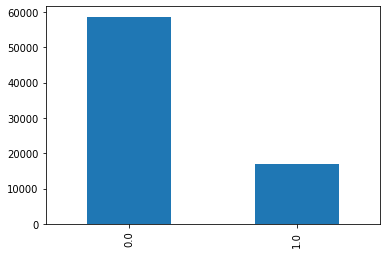

In [ ]:
#explore class distribution
class_count = data['Readmit'].value_counts().tolist()
print(f'The number of patients readmitted is {class_count[1]}({round(class_count[1]/sum(class_count)*100)}%)')
print(f'The number of patients not readmitted is {class_count[0]}({round(class_count[0]/sum(class_count)*100)}%)\n')

#plot
data['Readmit'].value_counts().plot.bar();

### Input Features
Define numeric and categorical variables.

In [ ]:
#define numeric and categorical variables
numeric = ['LengthofStay', 'PriorIPAdmits', 'PatientAge', 'TotalCharges',
           'bmi']

categorical = ['ChronicConditionsNumber', 'OrderSetUsed', 'DischargeNotes',
               'PatientGender', 'UrbanClass', 'MaritalStatus', 
               'RepeatCareGapOffenders', 'HighNAastDischarge',
               'ContactPreference']

data[categorical] = data[categorical].astype('category')

KeyError: ignored

Check for missing values and handle if required.

In [ ]:
#check for missing values
data.isnull().any()

diagnosis                  False
Readmit                    False
LengthofStay               False
PriorIPAdmits              False
ChronicConditionsNumber    False
PatientAge                 False
OrderSetUsed               False
TotalCharges               False
DischargeNotes             False
PatientGender              False
UrbanClass                 False
MaritalStatus              False
RepeatCareGapOffenders     False
HighNAastDischarge         False
bmi                        False
ContactPreference          False
dtype: bool

#### Catergorical Variables
Plot categorical variables to see cardinality, frequency of each class, split of the target variable.

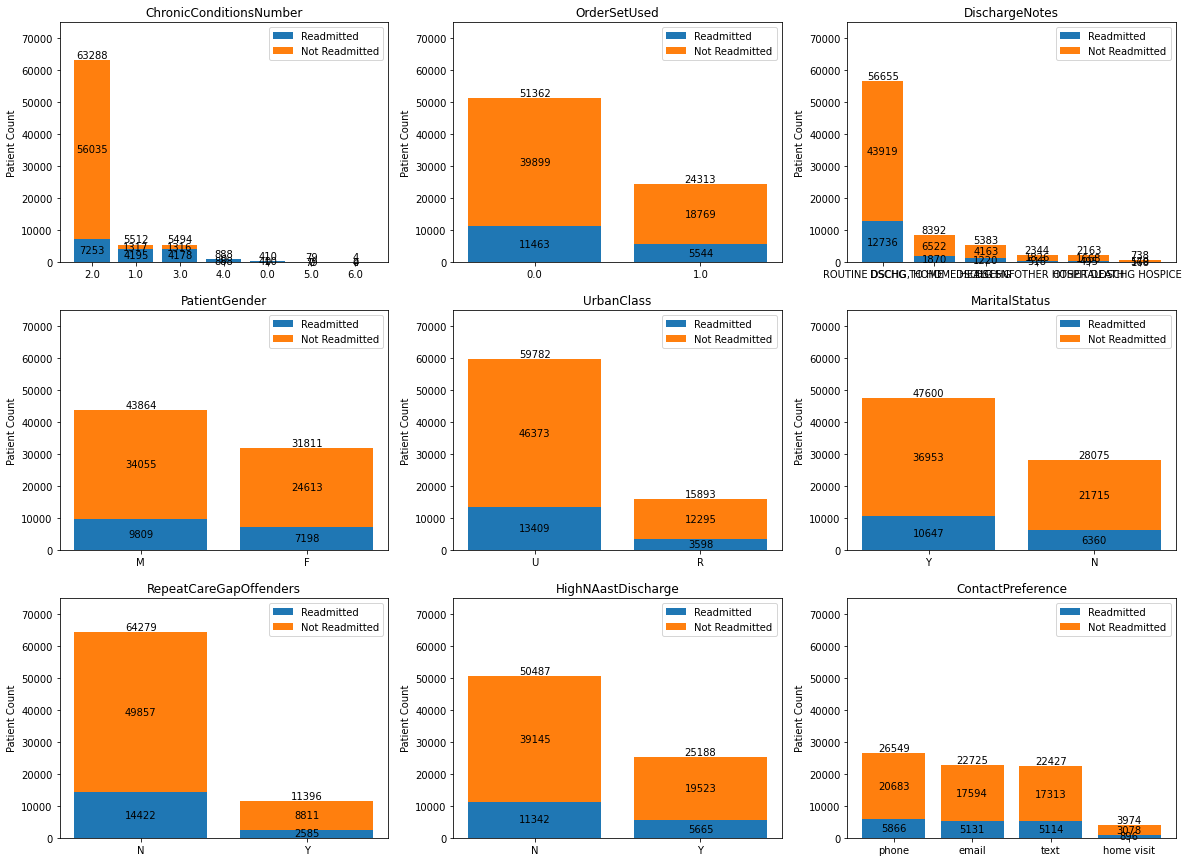

In [ ]:
#Plot categorical variables by readmission
#create positive/negative data set
data_pos = data.where(data['Readmit'] == 1)
data_neg = data.where(data['Readmit'] == 0)

#create 3 x 3 grid of bar charts
fig, ax = plt.subplots(3, 3, figsize=(20, 15))

i = 0;
j = 0;
for feature in data[categorical]:
  #set the number of bars to the number of category values
  x = np.arange(data[feature].value_counts().count())

  #create y positive and y negative based on frequency
  y_pos = data_pos[feature].value_counts()
  y_neg = data_neg[feature].value_counts()

  #create plots
  plot_pos = ax[i,j].bar(x, y_pos, label='Readmitted')
  plot_neg = ax[i,j].bar(x, y_neg, bottom=y_pos, label='Not Readmitted')
  
  #set axes and plot options
  ax[i,j].set_title(feature)
  ax[i,j].set_ylabel('Patient Count')
  ax[i,j].set_ylim(0, 75000)
  ax[i,j].set_xticks(x)
  ax[i,j].set_xticklabels(data[feature].value_counts().index)
  ax[i,j].legend()
  
  #add bar labels
  ax[i,j].bar_label(plot_pos, label_type='center')
  ax[i,j].bar_label(plot_neg, label_type='center')
  ax[i,j].bar_label(plot_neg)

  #set subplot index
  j = j + 1;
  if j == 3:
    i = i + 1;
    j = 0;

Chronic condition numbers 0, 4, 5, and 6 are very low occuring. Bin together.

In [ ]:
#bin the lowest occuring Chronic Conditions Number
data['ChronicConditionsNumber'] = data['ChronicConditionsNumber'].replace([0, 4, 5, 6],'other')

Encode categorical variables using one-hot encoding.

In [ ]:
#one-hot encode categorical variables
data = pd.get_dummies(data, drop_first=True)
data.head()

,Readmit,LengthofStay,PriorIPAdmits,PatientAge,TotalCharges,bmi,diagnosis_CABG,diagnosis_COPD,diagnosis_HF,diagnosis_HIP/KNEE,diagnosis_PN,ChronicConditionsNumber_1.0,ChronicConditionsNumber_2.0,ChronicConditionsNumber_3.0,OrderSetUsed_1.0,DischargeNotes_DSCHG OTHER HOSPITAL,DischargeNotes_DSCHG SNF,DischargeNotes_DSCHG TO HOME HEALTH,DischargeNotes_OTHER DEATH,"DischargeNotes_ROUTINE DSCHG, HOME",PatientGender_M,UrbanClass_U,MaritalStatus_Y,RepeatCareGapOffenders_Y,HighNAastDischarge_Y,ContactPreference_home visit,ContactPreference_phone,ContactPreference_text
0,1.0,7.0,5.0,44.0,12226.25,23.2,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,1,1,0,0
1,0.0,5.0,5.0,62.0,12518.75,24.3,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,1
2,0.0,3.0,4.0,54.0,7648.75,27.2,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0
3,1.0,5.0,5.0,79.0,8305.00,26.8,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,1,1,0,0,0,0,1
4,0.0,4.0,4.0,54.0,12697.50,25.3,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,1


#### Numeric Variables
Explore the distribution and relationships of the numeric variables.

In [ ]:
data[numeric].describe()

,LengthofStay,PriorIPAdmits,PatientAge,TotalCharges,bmi
count,75675.000000,75675.000000,75675.000000,75675.000000,75675.000000
mean,4.816597,4.496426,58.088008,17527.352403,24.508651
std,2.779307,0.642059,13.011104,14557.732770,3.500037
min,0.000000,2.000000,13.000000,1.250000,7.300000
25%,3.000000,4.000000,49.000000,8674.700000,22.100000
50%,4.000000,4.000000,57.000000,13242.500000,24.500000
75%,6.000000,5.000000,66.000000,21344.375000,26.900000
max,27.000000,8.000000,120.000000,166615.312500,40.700000


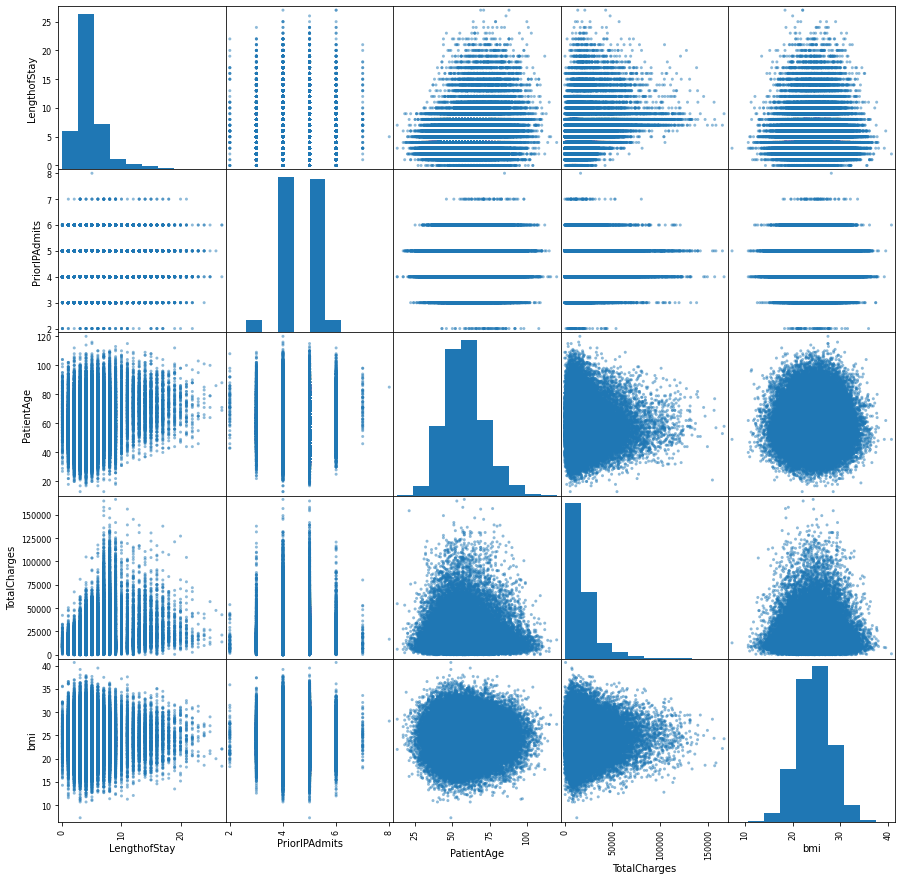

In [ ]:
#plot distribution and scatter plots of input variables
pd.plotting.scatter_matrix(data[numeric], figsize = (15,15));

Check the skewness and kurtosis values of the numeric features.

In [ ]:
#get skewness values
data[numeric].skew()

LengthofStay     2.008720
PriorIPAdmits    0.002691
PatientAge       0.485580
TotalCharges     2.633820
bmi              0.006907
dtype: float64

In [ ]:
#get kurtosis values
data[numeric].kurtosis()

LengthofStay      6.462872
PriorIPAdmits     0.010283
PatientAge        0.327282
TotalCharges     10.368210
bmi               0.005220
dtype: float64

## 4. Split into Train, Validation, and Test

In [ ]:
#set inputs and targets, split into train/test
X = data.drop('Readmit', axis=1)
y = data['Readmit']

#Split 60% train, 20% val, 20%, test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=40)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=40)

print('Size of training data:', X_train.shape)

Size of training data: (45405, 27)


## 5. Feature Selection
Handle correlated features if required. Perform PCA and assess if it is an appropriate option.

In [ ]:
#look at correlation between variables
pd.concat([X_train, y_train], axis = 1).corr()
#X_train[['DischargeNotes_ROUTINE DSCHG, HOME', 'PatientGender_M', 'UrbanClass_U', 'MaritalStatus_Y', 'HighNAastDischarge_Y']].corr()

,LengthofStay,PriorIPAdmits,PatientAge,TotalCharges,bmi,diagnosis_CABG,diagnosis_COPD,diagnosis_HF,diagnosis_HIP/KNEE,diagnosis_PN,ChronicConditionsNumber_1.0,ChronicConditionsNumber_2.0,ChronicConditionsNumber_3.0,OrderSetUsed_1.0,DischargeNotes_DSCHG OTHER HOSPITAL,DischargeNotes_DSCHG SNF,DischargeNotes_DSCHG TO HOME HEALTH,DischargeNotes_OTHER DEATH,"DischargeNotes_ROUTINE DSCHG, HOME",PatientGender_M,UrbanClass_U,MaritalStatus_Y,RepeatCareGapOffenders_Y,HighNAastDischarge_Y,ContactPreference_home visit,ContactPreference_phone,ContactPreference_text,Readmit
LengthofStay,1.000000,-0.001047,0.283814,0.374384,-0.000040,0.423044,-0.174179,-0.297750,0.180800,-0.077863,0.228094,-0.324263,0.120806,0.148272,-0.002871,0.006945,0.001417,0.013161,-0.007857,-0.006181,-0.010422,-0.006930,0.010689,0.004351,-0.004968,-0.004527,0.007848,0.482735
PriorIPAdmits,-0.001047,1.000000,-0.001346,-0.000559,0.000316,0.002046,0.008734,-0.007028,0.000027,-0.004382,-0.004300,0.004516,0.002201,0.011722,-0.003855,-0.003200,0.001842,0.003092,0.000202,-0.000948,0.000077,0.000156,-0.002241,0.000044,-0.002011,-0.002751,0.002858,-0.005140
PatientAge,0.283814,-0.001346,1.000000,-0.029985,-0.001472,-0.002270,0.038502,0.038807,-0.078758,0.015047,0.201825,-0.345814,0.211944,0.174354,-0.002725,-0.007240,-0.004559,0.003130,0.007353,0.002585,0.003622,0.004729,-0.004229,-0.006639,-0.004337,-0.002854,0.008126,0.580018
TotalCharges,0.374384,-0.000559,-0.029985,1.000000,-0.005349,0.657716,-0.206523,-0.209066,0.241516,-0.229176,-0.038154,-0.011273,-0.005634,-0.020822,-0.001793,-0.003600,-0.001192,0.005033,0.003700,0.003061,0.002146,0.002602,-0.003877,-0.004209,0.003144,-0.003255,0.000835,-0.058751
bmi,-0.000040,0.000316,-0.001472,-0.005349,1.000000,-0.004018,0.003053,-0.000138,0.005025,-0.000677,-0.001717,0.000158,0.001638,-0.010087,0.006225,0.008436,-0.002816,-0.006109,-0.002043,-0.005863,-0.003980,-0.007640,0.003448,0.006630,0.003067,0.009727,-0.002559,0.003116
diagnosis_CABG,0.423044,0.002046,-0.002270,0.657716,-0.004018,1.000000,-0.114904,-0.141669,-0.174837,-0.148942,-0.060117,-0.065307,0.052703,-0.002032,-0.001139,-0.003103,-0.002746,0.006084,0.004748,0.006355,0.003204,0.002565,-0.002796,-0.004136,0.005369,0.000427,0.001742,-0.006320
diagnosis_COPD,-0.174179,0.008734,0.038502,-0.206523,0.003053,-0.114904,1.000000,-0.193997,-0.239416,-0.203957,-0.066738,-0.021712,0.104066,0.010449,-0.000300,-0.002177,0.001119,-0.006543,0.004251,-0.001531,0.004187,-0.000717,-0.005661,0.000601,0.008230,-0.010374,0.000343,0.051815
diagnosis_HF,-0.297750,-0.007028,0.038807,-0.209066,-0.000138,-0.141669,-0.193997,1.000000,-0.295184,-0.251465,-0.084759,-0.034281,0.142677,0.025425,-0.002022,0.003488,-0.003742,0.001078,0.000459,0.004328,0.000571,0.004203,0.001441,-0.001575,-0.003555,0.005838,-0.003397,0.077973
diagnosis_HIP/KNEE,0.180800,0.000027,-0.078758,0.241516,0.005025,-0.174837,-0.239416,-0.295184,1.000000,-0.310338,0.011338,0.090247,-0.112169,-0.045816,0.001196,-0.000129,-0.001949,0.005679,-0.001765,-0.006127,0.000663,-0.003299,0.001030,0.000692,-0.007994,-0.006795,-0.001636,-0.141437
diagnosis_PN,-0.077863,-0.004382,0.015047,-0.229176,-0.000677,-0.148942,-0.203957,-0.251465,-0.310338,1.000000,0.113419,-0.007326,-0.088924,0.013619,0.001487,0.004728,0.004580,0.000949,-0.008248,-0.000018,-0.009223,-0.003052,0.006752,0.005428,0.002673,0.006416,0.002115,0.027139


#### Principle Component Analysis

In [ ]:
#center and scale
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scale = scaler.transform(X_train)
X_val_scale = scaler.transform(X_val)

accuracy = []
components = []
n_columns = X_train.shape[1]
min_columns = int(n_columns / 2 + 1)
for i in range(min_columns):

  #pca
  n_components = n_columns - i
  pca = PCA(n_components = n_components)
  pca.fit(X_train_scale)
  X_train_pca = pca.transform(X_train_scale)
  X_val_pca = pca.transform(X_val_scale)

  #Logistic Regression
  clf = LogisticRegression(max_iter=200)

  #train
  clf.fit(X_train_pca, y_train)

  #evaluate
  y_pred = clf.predict(X_val_pca)
  accuracy.append(accuracy_score(y_val, y_pred))
  components.append(n_components)

  print(f'Accuracy:{accuracy[i]:.5f} Components: {n_components}')

Accuracy:0.95342 Components: 27
Accuracy:0.95355 Components: 26
Accuracy:0.95335 Components: 25
Accuracy:0.95177 Components: 24
Accuracy:0.95177 Components: 23
Accuracy:0.95177 Components: 22
Accuracy:0.95137 Components: 21
Accuracy:0.95150 Components: 20
Accuracy:0.94199 Components: 19
Accuracy:0.94205 Components: 18
Accuracy:0.93360 Components: 17
Accuracy:0.93353 Components: 16
Accuracy:0.92329 Components: 15
Accuracy:0.92355 Components: 14


Plot validation accuracy achieved as the number of components decreases.

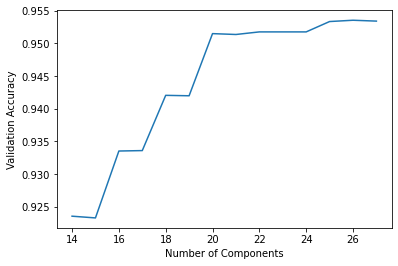

In [ ]:
plt.plot(components, accuracy)
plt.xlabel('Number of Components')
plt.ylabel('Validation Accuracy');

## 6. Normalize
Take the log of the variables with large outliers. Normalize all variables to be between 0 and 1 using min/max scaling.

In [ ]:
class Normalize():
  #take the log transform of TotalCharges and use min/mx scaling to normalize
  
  def fit(self, df):
    #log transform 'Total Charges'
    df['TotalCharges'] = np.log(df['TotalCharges'])

    #save training min max
    self.min = df[numeric].min()
    self.max = df[numeric].max()
  
  def transform(self, df):
    #log transform 'TotalCharges'
    df['TotalCharges'] = np.log(df['TotalCharges'])

    #normalize with z-score
    df[numeric] = (df[numeric] - self.min)  / (self.max - self.min)
    
    return df

In [ ]:
#normalize data
norm = Normalize()

#fit to training min/max values
norm.fit(X_train)

#normalize with training min/max values
X_train_norm= norm.transform(X_train)
X_val_norm = norm.transform(X_val)
X_test_norm = norm.transform(X_test)

## 7. Build Models
Build 5 models on training data:
*   Logistic Regression (Sklearn - showing feature importance)
*   Support Vector Machine (Sklearn - with GridSearch for kernel, C, and gamma)
*   K-Nearest Neighbours (Sklearn - with GridSearch for number of neighbours)
*   Neural Network (Keras)
*   Gradient Boosting (SAS - with autonuning)

Assess accuracy, recall, and precision using validation data. Display the confusion matrix for each.

### Logistic Regression

Train Accuracy: 0.950
Train Recall: 0.838
Train Precision: 0.935

Validation Accuracy: 0.953
Validation Recall: 0.854
Validation Precision: 0.934


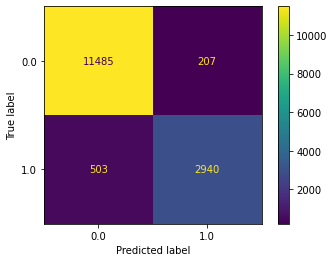

In [ ]:
#Logistic Regression
clf_logreg = LogisticRegression(max_iter=200)

#train
clf_logreg.fit(X_train_norm, y_train)

#evaluate
y_pred = clf_logreg.predict(X_train_norm)
print(f'Train Accuracy: {accuracy_score(y_train, y_pred):.3f}')
print(f'Train Recall: {recall_score(y_train, y_pred):.3f}')
print(f'Train Precision: {precision_score(y_train, y_pred):.3f}')

y_pred = clf_logreg.predict(X_val_norm)
y_scores_logreg = clf_logreg.predict_proba(X_val_norm)
print(f'\nValidation Accuracy: {accuracy_score(y_val, y_pred):.3f}')
print(f'Validation Recall: {recall_score(y_val, y_pred):.3f}')
print(f'Validation Precision: {precision_score(y_val, y_pred):.3f}')

ConfusionMatrixDisplay.from_estimator(clf_logreg, X_val_norm, y_val);

View the absolute feature importance for the logistic regression model.

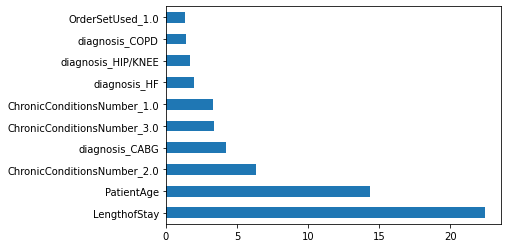

In [ ]:
#feature importance
pd.Series(abs(np.ravel(clf_logreg.coef_)), index=X.columns).nlargest(10).plot(kind='barh');

### Support Vector Machine
Use grid search and 5-fold cross validation to determine the kernel (rbf or linear), C, and gamma.

In [ ]:
#SVM
#perform grid serach with cross validation to select hyperparameters
parameters = { 'kernel': ['rbf', 'linear'],
              'C': [10, 100, 1000],
              'gamma':[0.001, 0.01, 0.1]}
svc = SVC()

#perform gridsearch to select best parameters
clf_search = GridSearchCV(estimator=svc, param_grid=parameters)

#train
clf_search.fit(X_train_norm.iloc[0:10000,:], y_train.iloc[0:10000])
print('Selected hyperparameters:', clf_search.best_params_)


Selected hyperparameters: {'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}


Train Accuracy: 0.959
Train Recall: 0.855
Train Precision: 0.957

Validation Accuracy: 0.925
Validation Recall: 0.933
Validation Precision: 0.779


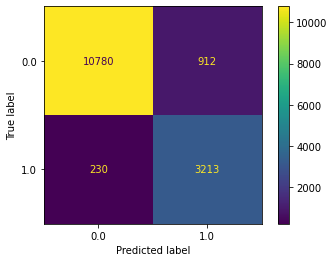

In [ ]:
#train on full training data with best parameters
clf_svm = SVC(**clf_search.best_params_, probability=True)


#train
clf_svm.fit(X_train_norm, y_train)

#evaluate
y_pred = clf_svm.predict(X_train_norm)
print(f'Train Accuracy: {accuracy_score(y_train, y_pred):.3f}')
print(f'Train Recall: {recall_score(y_train, y_pred):.3f}')
print(f'Train Precision: {precision_score(y_train, y_pred):.3f}')

y_pred = clf_svm.predict(X_val_norm)
y_scores_svm = clf_svm.predict_proba(X_val_norm)
print(f'\nValidation Accuracy: {accuracy_score(y_val, y_pred):.3f}')
print(f'Validation Recall: {recall_score(y_val, y_pred):.3f}')
print(f'Validation Precision: {precision_score(y_val, y_pred):.3f}')

ConfusionMatrixDisplay.from_estimator(clf_svm, X_val_norm, y_val);

### K-Nearest Neighbours
Use grid search and 5-fold cross validation to determine the number of neighbours.

In [ ]:
#KNN
#perform grid search with cross validation to select hyperparameters
parameters = { 'n_neighbors':list(np.arange(1,10))}
knn = KNeighborsClassifier()

#train
clf_knn = GridSearchCV(estimator=knn, param_grid=parameters)
clf_knn.fit(X_train_norm, y_train)
print('Selected hyperparameters:', clf_knn.best_params_)

Selected hyperparameters: {'n_neighbors': 3}


Train Accuracy: 0.956
Train Recall: 0.843
Train Precision: 0.958

Validation Accuracy: 0.931
Validation Recall: 0.768
Validation Precision: 0.916


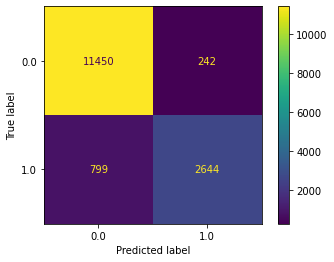

In [ ]:
#evaluate
y_pred = clf_knn.predict(X_train_norm)
print(f'Train Accuracy: {accuracy_score(y_train, y_pred):.3f}')
print(f'Train Recall: {recall_score(y_train, y_pred):.3f}')
print(f'Train Precision: {precision_score(y_train, y_pred):.3f}')

y_pred = clf_knn.predict(X_val_norm)
y_scores_knn = clf_knn.predict_proba(X_val_norm)
print(f'\nValidation Accuracy: {accuracy_score(y_val, y_pred):.3f}')
print(f'Validation Recall: {recall_score(y_val, y_pred):.3f}')
print(f'Validation Precision: {precision_score(y_val, y_pred):.3f}')

ConfusionMatrixDisplay.from_estimator(clf_knn, X_val_norm, y_val);

### Neural Network
Build a 4 dense layer and single output layer neural network with a sigmoid activation function.

In [ ]:
model = tf.keras.models.Sequential([

        tf.keras.Input(shape=X_train.shape[1:]),   

        tf.keras.layers.Dense(256), 
        tf.keras.layers.Activation('sigmoid'),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Dense(128), 
        tf.keras.layers.Activation('sigmoid'),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Dense(128), 
        tf.keras.layers.Activation('sigmoid'),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Dense(64), 
        tf.keras.layers.Activation('sigmoid'),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Dense(1),
        tf.keras.layers.Activation('sigmoid')
])

model.compile(loss="binary_crossentropy", optimizer="adam", 
              metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision(),"accuracy"])

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train, y_train, epochs=1000, 
                    validation_split=0.1, callbacks=[early_stop], verbose=0)

hist = pd.DataFrame(history.history)
hist["epoch"] = history.epoch

hist.tail(1)

,loss,recall,precision,accuracy,val_loss,val_recall,val_precision,val_accuracy,epoch
66,0.121331,0.86112,0.950012,0.958717,0.105735,0.863289,0.963714,0.961022,66


Plot the training and validation error at each epoch.

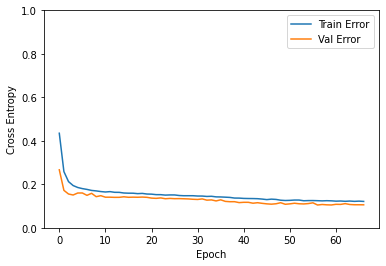

In [ ]:
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.plot(hist['epoch'], hist['loss'], label='Train Error')
plt.plot(hist['epoch'], hist['val_loss'], label='Val Error')
plt.ylim([0,1])
plt.legend();

Evaluate on validation data.

473/473 [==============================] - 1s 2ms/step - loss: 0.1106 - recall: 0.8397 - precision: 0.9820 - accuracy: 0.9600

Validation Accuracy: 0.960
Validation Recall: 0.840
Validation Precision: 0.982


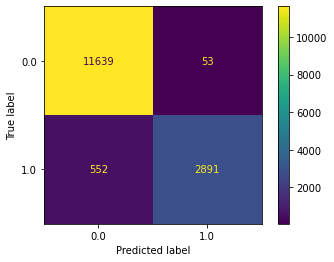

In [ ]:
#evaluate on validation data
_, recall, precision, accuracy = model.evaluate(X_val_norm, y_val)
print(f'\nValidation Accuracy: {accuracy:.3f}')
print(f'Validation Recall: {recall:.3f}')
print(f'Validation Precision: {precision:.3f}')

#predict
y_scores_nn = model.predict(X_val_norm)

ConfusionMatrixDisplay.from_predictions(y_val, np.round_(y_score_nn));

### SAS Auto-tuned Gradient Boosting Model
Move preprocessed data into CAS. Build a model on SAS Viya using the autotune CAS actionset.

In [ ]:
#create a dataset to load to cas
#add training with a partition indicator
train = X_train
train['Readmit'] = y_train.astype('category')
train['_PARTIND_'] = 0

#add validation with a partition indicator
val = X_val
val['Readmit'] = y_val.astype('category')
val['_PARTIND_'] = 1

#add validation with a partition indicator
test = X_test
test['Readmit'] = y_test.astype('category')
test['_PARTIND_'] = 2

#combine train and validation
data_final = train.append(val.append(test))

Load data into CAS from python environment.

In [ ]:
#Load preprocessed modeling table to CAS
conn.upload_frame(data_final, casout=dict(name='PATIENT_READMISSION_MODEL', caslib = 'CASUSER', replace=True))

NOTE: Cloud Analytic Services made the uploaded file available as table PATIENT_READMISSION_MODEL in caslib CASUSER(Marie.Coolsaet@sas.com).
NOTE: The table PATIENT_READMISSION_MODEL has been created in caslib CASUSER(Marie.Coolsaet@sas.com) from binary data uploaded to Cloud Analytic Services.


CASTable('PATIENT_READMISSION_MODEL', caslib='CASUSER(Marie.Coolsaet@sas.com)')

In [ ]:
#load autotune action set
conn.loadActionSet('autotune')
actions=conn.builtins.help(actionSet='autotune')

NOTE: Added action set 'autotune'.
NOTE: Information for action set 'autotune':
NOTE:    autotune
NOTE:       tuneSvm - Automatically adjusts support vector machine parameters to tune a model for minimum error
NOTE:       tuneForest - Automatically adjusts forest parameters to tune a model for minimum error
NOTE:       tuneDecisionTree - Automatically adjusts decision tree parameters to tune a model for minimum error
NOTE:       tuneNeuralNet - Automatically adjusts neural network parameters to tune a model for minimum error
NOTE:       tuneGradientBoostTree - Automatically adjusts gradient boosting tree parameters to tune a model for minimum error
NOTE:       tuneFactMac - Automatically adjusts factorization machine parameters to tune a model for minimum error
NOTE:       tuneBnet - Automatically adjusts Bayesian network classifier parameters to tune a model for minimum error
NOTE:       tuneTsne - Automatically adjusts t-Distributed Stochastic Neighbor Embedding algorithm parameters 

Train the model using the training data. (All training and data is on CAS)

In [ ]:
conn.autotune.tuneGradientBoostTree(
            trainOptions=dict(
            table=dict(name= 'PATIENT_READMISSION_MODEL', where="_PARTIND_=0", caslib = 'CASUSER'),
            target='Readmit',
            inputs=list(X),
            nominals= 'Readmit',
            casOut=dict(name='gb_tuned_readmit_swat',replace=True)),
            tunerOptions=dict(seed=802, maxEvals=1000, maxTime=1800,
                              objective='MSE',))

NOTE: Autotune is started for 'Gradient Boosting Tree' model.
NOTE: Autotune option SEARCHMETHOD='GA'.
NOTE: Autotune option MAXEVALS=1000.
NOTE: Autotune option MAXTIME=1800 (sec.).
NOTE: Autotune option SEED=802.
NOTE: Autotune objective is 'Mean Square Error'.
NOTE: Early stopping is activated; 'NTREE' will not be tuned.
NOTE: Autotune number of parallel evaluations is set to 4, each using 1 worker nodes.
NOTE: Automatic early stopping is activated with STAGNATION=4;  set EARLYSTOP=false to deactivate.
         Iteration       Evals     Best Objective  Elapsed Time
                 0           1             0.0303          5.41
                 1          25             0.0292         26.66
                 2          46             0.0292         40.99
                 3          68             0.0291         62.23
                 4          88             0.0291         79.43
                 5         108             0.0291         96.67
NOTE: Data was partitioned during tuning,

,Parameter,Name,Value
0,Evaluation,Evaluation,57
1,Number of Variables to Try,M,14
2,Learning Rate,LEARNINGRATE,0.505
3,Sampling Rate,SUBSAMPLERATE,1
4,Lasso,LASSO,7.5
5,Ridge,RIDGE,5
6,Number of Bins,NBINS,60
7,Maximum Tree Levels,MAXLEVEL,5
8,Mean Square Error,Objective,0.0291336553
,LEVNAME,LEVINDEX,VARNAME


Score the validation data to assess model performance.

In [ ]:
#Score Gradient Boosting on validation
conn.decisionTree.gbtreeScore(
            table=dict(name='PATIENT_READMISSION_MODEL', where="_PARTIND_=1"),
            model=dict(name="gb_tuned_readmit_swat", caslib = 'CASUSER'),
            casout=dict(name="gb_scored_readmit_swat", replace=True, caslib='CASUSER'),
            copyvars='Readmit',
            encodeName=True,
            assess=True)

[EncodedName]

         LEVNAME  LEVINDEX     VARNAME
 0             1         0  P_Readmit1
 1             0         1  P_Readmit0

[EncodedTargetName]

   LEVNAME  LEVINDEX    VARNAME
 0                 0  I_Readmit

[ErrorMetricInfo]

     TreeID  Trees  NLeaves       MCR   LogLoss       ASE      RASE     MAXAE
 0      0.0    1.0     12.0  0.087083  0.308485  0.082159  0.286634  0.857920
 1      1.0    2.0     28.0  0.076379  0.246877  0.063272  0.251538  0.911556
 2      2.0    3.0     44.0  0.062768  0.209306  0.053400  0.231085  0.942075
 3      3.0    4.0     59.0  0.059795  0.188628  0.049067  0.221511  0.962086
 4      4.0    5.0     72.0  0.054906  0.169851  0.044395  0.210701  0.971768
 5      5.0    6.0     88.0  0.054377  0.163090  0.043509  0.208588  0.979703
 6      6.0    7.0     97.0  0.055104  0.158087  0.042247  0.205540  0.982726
 7      7.0    8.0    111.0  0.047308  0.141132  0.037667  0.194079  0.986239
 8      8.0    9.0    119.0  0.047308  0.136820  0.036665  0.191482  0.990064
 9      9.0   10.0    131.0  0.045325  0.129213  0.034849  0.186680  0.993163
 10    10.0   11.0    142.0  0.044731  0.126471  0.034259  0.185091  0.994265
 11    11.0   12.0    154.0  0.043079  0.122688  0.033172  0.182133  0.995622
 12    12.0   13.0    165.0  0.042352  0.120185  0.032500  0.180278  0.996127
 13    13.0   14.0    173.0  0.039907  0.115742  0.031191  0.176609  0.996567
 14    14.0   15.0    186.0  0.039974  0.115278  0.031188  0.176601  0.996436
 15    15.0   16.0    196.0  0.038256  0.112321  0.030329  0.174154  0.996819
 16    16.0   17.0    208.0  0.038652  0.111614  0.030208  0.173805  0.996898
 17    17.0   18.0    221.0  0.038057  0.109469  0.029603  0.172055  0.996883
 18    18.0   19.0    232.0  0.037331  0.109205  0.029540  0.171872  0.996787
 19    19.0   20.0    243.0  0.037199  0.108529  0.029377  0.171398  0.996853
 20    20.0   21.0    255.0  0.036141  0.107063  0.028904  0.170011  0.996853
 21    21.0   22.0    270.0  0.036075  0.105432  0.028432  0.168617  0.997328
 22    22.0   23.0    284.0  0.035877  0.104512  0.028232  0.168022  0.997633
 23    23.0   24.0    296.0  0.036207  0.104082  0.028146  0.167766  0.997591
 24    24.0   25.0    310.0  0.035811  0.103214  0.027856  0.166902  0.997591
 25    25.0   26.0    324.0  0.034754  0.102032  0.027488  0.165795  0.997591
 26    26.0   27.0    336.0  0.034952  0.101760  0.027425  0.165605  0.997640
 27    27.0   28.0    344.0  0.034820  0.101645  0.027417  0.165582  0.997640
 28    28.0   29.0    358.0  0.034754  0.101640  0.027428  0.165613  0.997638
 29    29.0   30.0    368.0  0.034820  0.101454  0.027383  0.165478  0.997638
 30    30.0   31.0    379.0  0.034688  0.101124  0.027291  0.165199  0.997685
 31    31.0   32.0    389.0  0.034622  0.100975  0.027253  0.165084  0.997665
 32    32.0   33.0    403.0  0.034820  0.100616  0.027142  0.164747  0.997733
 33    33.0   34.0    418.0  0.034225  0.100104  0.026979  0.164252  0.997733
 34    34.0   35.0    433.0  0.033895  0.100029  0.026967  0.164217  0.997760
 35    35.0   36.0    449.0  0.033499  0.099856  0.026911  0.164046  0.997787
 36    36.0   37.0    464.0  0.033366  0.099510  0.026783  0.163656  0.997856
 37    37.0   38.0    479.0  0.033234  0.099434  0.026759  0.163582  0.997856
 38    38.0   39.0    493.0  0.033234  0.099498  0.026779  0.163644  0.997855
 39    39.0   40.0    503.0  0.032838  0.099417  0.026763  0.163593  0.997875
 40    40.0   41.0    515.0  0.032772  0.099050  0.026655  0.163264  0.997895
 41    41.0   42.0    526.0  0.032706  0.099085  0.026675  0.163326  0.998013
 42    42.0   43.0    538.0  0.033234  0.099104  0.026680  0.163341  0.998036
 43    43.0   44.0    550.0  0.033234  0.099073  0.026687  0.163363  0.998045

[OutputCasTables]

                             casLib                    Name   Rows  Columns                                           casTable
 0  CASUSER(Marie.Coolsaet@sas.com)  gb_scored_readmit_swat  30270        5  CASTable('gb_scored_readmit_

Bring the scored data back to the python environment.

In [ ]:
#Load scored data from CAS
gb_scored = conn.CASTable(name='gb_scored_readmit_swat',caslib="CASUSER").to_frame()
gb_scored = gb_scored.where(gb_scored['_GBT_Level_'].astype('int')==1).dropna()
gb_scored.head()

,Readmit,I_Readmit,_MissIt_,_GBT_Level_,_GBT_P_
0,1.0,1,0.0,1,0.999818
2,0.0,0,0.0,1,0.033693
4,0.0,0,0.0,1,0.010156
6,0.0,0,0.0,1,0.002592
8,1.0,1,0.0,1,0.999737


Use the scored data from CAS to get assessment metrics.


Validation Accuracy: 0.967
Validation Recall: 0.895
Validation Precision: 0.956


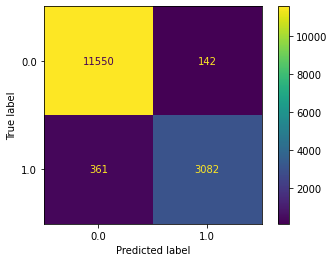

In [ ]:
#Assess on validation data
y_pred = gb_scored['I_Readmit'].astype('int')
y_val_gb = gb_scored['Readmit']
y_scores_gb = gb_scored['_GBT_P_']

print(f'\nValidation Accuracy: {accuracy_score(y_val_gb, y_pred):.3f}')
print(f'Validation Recall: {recall_score(y_val_gb, y_pred):.3f}')
print(f'Validation Precision: {precision_score(y_val_gb, y_pred):.3f}')

ConfusionMatrixDisplay.from_predictions(y_val_gb, y_pred);

## 8. Evaluate
Plot ROC curve for validation scores.

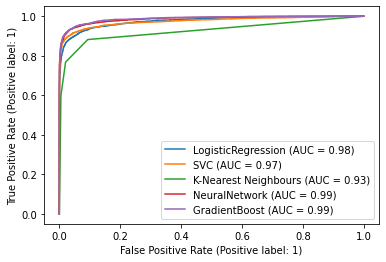

In [ ]:
#Plot ROC for all classifiers
ax = plt.gca()
RocCurveDisplay.from_estimator(clf_logreg, X_val_norm, y_val, ax=ax)
RocCurveDisplay.from_estimator(clf_svm, X_val_norm, y_val, ax=ax)
RocCurveDisplay.from_estimator(clf_knn, X_val_norm, y_val, ax=ax, name='K-Nearest Neighbours')
RocCurveDisplay.from_predictions(y_val, y_scores_nn, ax=ax, name='NeuralNetwork')
RocCurveDisplay.from_predictions(y_val_gb, y_scores_gb, ax=ax, name='GradientBoost')

Evaluate test data and get accuracy, precision, recall, and f1 score.

In [ ]:
#Get test accuracy, precision, recall, f1 score
metrics = np.zeros((4,5))

#Sklearn models
y_pred_logreg = clf_logreg.predict(X_test_norm)
y_pred_svm = clf_svm.predict(X_test_norm)
y_pred_knn = clf_knn.predict(X_test_norm)

#Sas Gradient Boosting Model
conn.decisionTree.gbtreeScore(
            table=dict(name='PATIENT_READMISSION_MODEL', where="_PARTIND_=2"),
            model=dict(name="gb_tuned_readmit_swat", caslib = 'CASUSER'),
            casout=dict(name="gb_test_readmit_swat", replace=True, caslib='CASUSER'),
            copyvars='Readmit',
            encodeName=True,
            assess=True)
gb_scored = conn.CASTable(name='gb_test_readmit_swat',caslib="CASUSER").to_frame()
gb_scored = gb_scored.where(gb_scored['_GBT_Level_'].astype('int')==1).dropna()
y_pred_gb = gb_scored['I_Readmit'].astype('int')


y_pred = [y_pred_logreg, y_pred_svm, y_pred_knn, y_pred_gb]
i = 0
for pred in y_pred:
  metrics[0,i] = accuracy_score(y_test, pred)
  metrics[1,i] = recall_score(y_test, pred)
  metrics[2,i] = precision_score(y_test, pred)

  i = i + 1

#NeuralNet
_, metrics[1,4], metrics[2,4], metrics[0,4] = model.evaluate(X_val_norm, y_val)

#calculate f1
metrics[3,:] = 2 / (1 / metrics[1,:] + 1 / metrics[2,:])

473/473 [==============================] - 1s 2ms/step - loss: 0.1106 - recall: 0.8397 - precision: 0.9820 - accuracy: 0.9600


Plot metrics

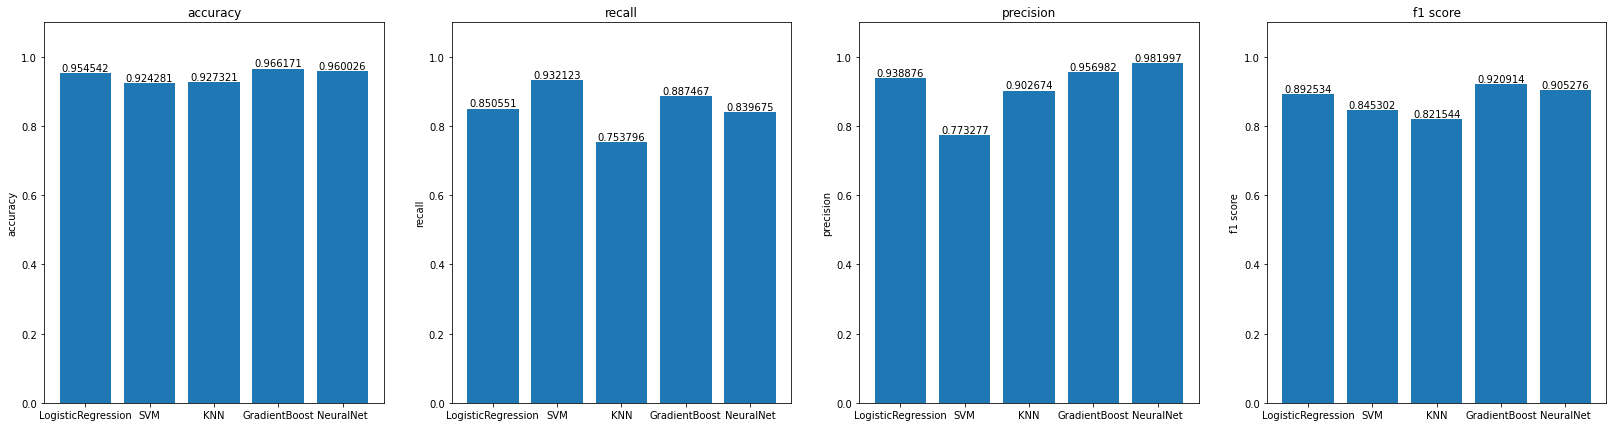

In [ ]:
#plot metrics
#create 3 x 3 grid of bar charts
fig, ax = plt.subplots(1,4, figsize=(28, 7))

models = ['LogisticRegression', 'SVM', 'KNN', 'GradientBoost', 'NeuralNet']
metric_label = ['accuracy', 'recall', 'precision', 'f1 score']
for i in range(4):
  #set the number of bars
  x = np.arange(5)

  #set y to test metric
  y = metrics[i,:]

  #create plots
  plot = ax[i].bar(x, y)
  
  #set axes and plot options
  ax[i].set_title(metric_label[i])
  ax[i].set_ylabel(metric_label[i])
  ax[i].set_ylim(0, 1.1)
  ax[i].set_xticks(x)
  ax[i].set_xticklabels(models)
  
  #add bar labels
  ax[i].bar_label(plot)

## 9. Register Best Models to Repository
Add the best performing model - gradient boosting and a strong performing interpretable model to the model repository. The model repository holds score code, model metadata, performance metrics in a project repository. Models can be put into production and monitored.

In [ ]:
#install sasctl to register SAS and python models to Model Manager
!pip install sasctl

     |████████████████████████████████| 134 kB 4.4 MB/s 


In [ ]:
#register two models to the patient readmission model repositor on SAS Viya
from sasctl import Session, register_model
gradient_boost=conn.CASTable(caslib = 'CASUSER', name = '"gb_tuned_readmit_swat")

with Session(conn):
    register_model(clf_logreg, 'Sklearn Model', 'Patient Readmission')
    register_model(gradient_boost, 'SAS Model', 'Patient Readmission')

## 10. Utilities

In [ ]:
!pip install matplotlib --upgrade

     |████████████████████████████████| 11.2 MB 1.6 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
